<a href="https://colab.research.google.com/github/EilieYoun/Narnia-Edu/blob/main/Lecture/240813_snu/02_2D_Field_Predict_%ED%95%B4%EC%84%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 서울대 예측 AI 실습 : 2D Field Predict

* 날짜:
* 이름:


## 학습내용
```
- 2D Field 데이터셋에 대해 이해하고 적절한 DataLoader를 구성 한다.
- 2D Field 예측 문제에 적합한 모델을 구성하고, 학습을 진행한다.
```

## **(0) 환경세팅**
---

### **| 라이브러리 설치**

In [ ]:
!pip install pytorch-lightning

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 63.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=bff613beb28f2c17803aca951dc708260f15c4246f1695b044cb4e4e02187652
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=9dc06cd38093de6eb169a641749c60297fc2eea31012ae9f8bb890adb22310c1
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

### **| 데이터 압축 풀기**

In [ ]:
!unzip carfield.zip -d ./carfield

### **| Utils**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

def draw(imgs=[], cmap='RdBu_r', rows=None, save_path=None, mn=None, mx=None, colorbar=True):
    num_imgs = len(imgs)
    imgs = [img.astype(np.float32) for img in imgs]

    if rows is None:
        rows = 1  # Default to a single row if rows not specified

    cols = (num_imgs + rows - 1) // rows  # Calculate the number of columns needed

    plt.figure(figsize=(5*cols+2, 5*rows))

    for i, img in enumerate(imgs):
        if mn is None:
          mn = min(img.min(), -img.max())
        if mx is None:
          mx = max(img.max(), -img.min())
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap=cmap, vmin=mn, vmax=mx)
        if colorbar:
          plt.colorbar(shrink=0.4)
        plt.axis('off')  # Hide axis for better visualization

    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

## **(1) Dataset**

### **| EDA**

**데이터 소개**

[`CADillac`](https://kilthub.cmu.edu/articles/dataset/CADillac/8262593) 데이터셋에는 1,000개 이상의 고품질 3D 차량 모델이 포함되어 있습니다. 각 차량 모델은 Blender의 .blend 형식으로 제공되며, 차량의 크기, 색상, 유형 등의 메타 정보가 JSON 파일에 저장되어 있습니다.

이번 시간에는 이 데이터를 가공한 2D 데이터를 사용합니다. 먼저, 각 차량의 3D 모델에 대해 풍동 실험의 CFD(전산유체역학) 시뮬레이션을 수행하여 시뮬레이션 공간 상의 3D 압력 필드를 계산했습니다. 이후, 차량의 3D 모델의 중앙 부분을 잘라 차량의 단면을 추출하고, 마찬가지로 3D 압력 필드의 중앙 부분 단면을 추출하여 각 차량의 단면과 해당 차량의 2D 압력 필드를 쌍으로 하는 데이터 셋을 만들었습니다. 이렇게 해서 총 367개의 데이터 쌍을 준비했습니다.

**데이터 경로 확보**

In [ ]:
import glob
image_paths= sorted(glob.glob('carfield/image/*npy'))
field_paths = sorted(glob.glob('carfield/field/*npy'))
print(len(image_paths), len(field_paths))

367 367


**데이터 시각화**

0 (1, 128, 256) (1, 128, 256)
1 (1, 128, 256) (1, 128, 256)
2 (1, 128, 256) (1, 128, 256)


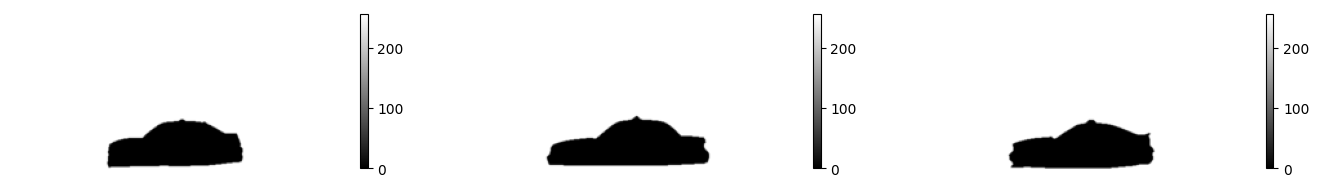

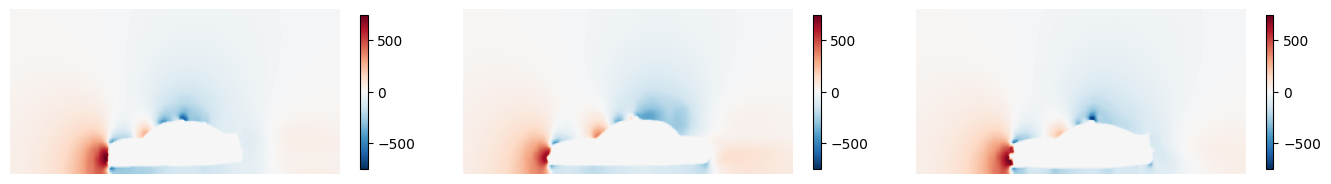

In [ ]:
image_sample = []
field_sample = []
for idx in range(3):
    image_path = image_paths[idx]
    field_path = field_paths[idx]
    image = np.load(image_path)
    field = np.load(field_path)
    print(idx, image.shape, field.shape)

    image_sample.append(image[0])
    field_sample.append(field[0])

draw(image_sample, mn=0, mx=255, cmap='gray')
draw(field_sample)

### **| DataLoader**

간략하게 데이터 구성을 확인했으니 이를 적절한 `DataLoader` 클래스를 구축하겠습니다. `DataLoader`는 아래와 같은 기능이 포함되어야 합니다.

```
- __init__ : 데이터셋 초기화.
    - image_paths : 입력 (이미지) 데이터 경로
    - field_paths : 출력 (필드) 데이터 경로
    - batch_size : 배치 크기.
    - shuffle : 데이터 셔플 여부.
    - dtype : 데이터 유형 (torch.float32)
    - aug : False : 데이터 증강

- __len__ : 데이터셋의 전체 길이를 반환.

- __getitem__ : 인덱스에 해당하는 데이터 항목을 반환.
    - 데이터셋 불러오기
    - 입력 데이터를 적절하게 스케일링
    - 출력 데이터를 적절하게 스케일링
    - 전처리된 인풋 텐서 (x)와 타깃 텐서 (y) 반환
    - 데이터 증강
    
- get_loader : 데이터 로더를 반환.

- get_batch : 지정된 인덱스의 배치를 반환.
```


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from torchvision import transforms


class CarFieldPorocess(Dataset):

    def __init__(self,
                 image_paths,
                 field_paths,
                 batch_size=8,
                 shuffle=True,
                 dtype=torch.float32,
                 aug=False
                ):
        # init
        self.image_paths = image_paths
        self.field_paths = field_paths

        self.n_image = len(self.image_paths)
        self.n_field = len(self.field_paths)

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dtype = dtype
        self.aug =aug

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        x = np.load(path)

        path = self.field_paths[idx]
        y = np.load(path)

        x = x / 255.
        y = y / 600.

        x = torch.tensor(x, dtype=self.dtype)
        y = torch.tensor(y, dtype=self.dtype)

        if self.aug:
            if random.choice([True, False]):
                flip = transforms.RandomHorizontalFlip(p=1)
                x = flip(x)
                y = flip(y)

        return x, y

    def get_loader(self):
        loader = DataLoader(self, batch_size=self.batch_size, shuffle=self.shuffle, pin_memory=True)
        return loader

    def get_batch(self, idx=0):
        ds = self.get_loader()
        for i, batch in enumerate(ds):
            if i == idx : break
        return batch

**데이터 분할**

In [ ]:
from sklearn.model_selection import train_test_split

# 학습/테스트 데이터 분리
train_image_paths, test_image_paths, train_field_paths, test_field_paths = train_test_split(
    image_paths, field_paths, test_size=0.1, random_state=43
)

print('- Total dataset: ', len(image_paths), len(field_paths))
print('- Train dataset: ', len(train_image_paths), len(train_field_paths))
print('- Test dataset: ', len(test_image_paths), len(test_field_paths))

- Total dataset:  367 367
- Train dataset:  330 330
- Test dataset:  37 37


**Processor 구축**

torch.Size([8, 1, 128, 256]) torch.Size([8, 1, 128, 256])


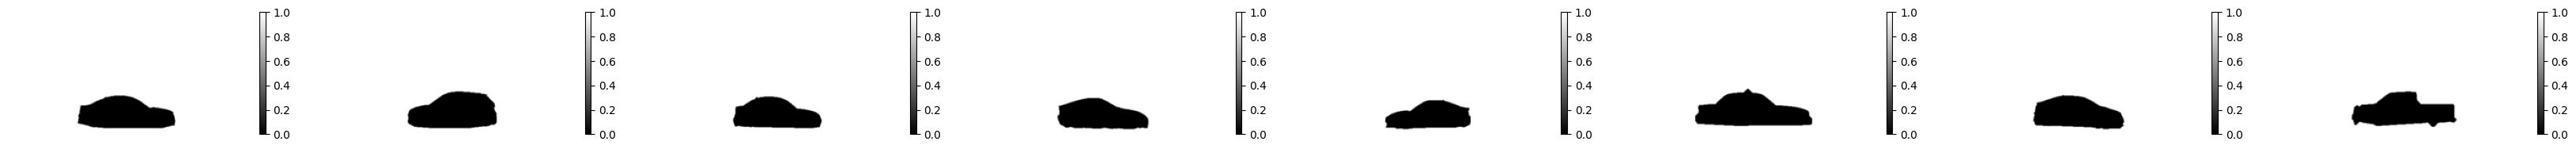

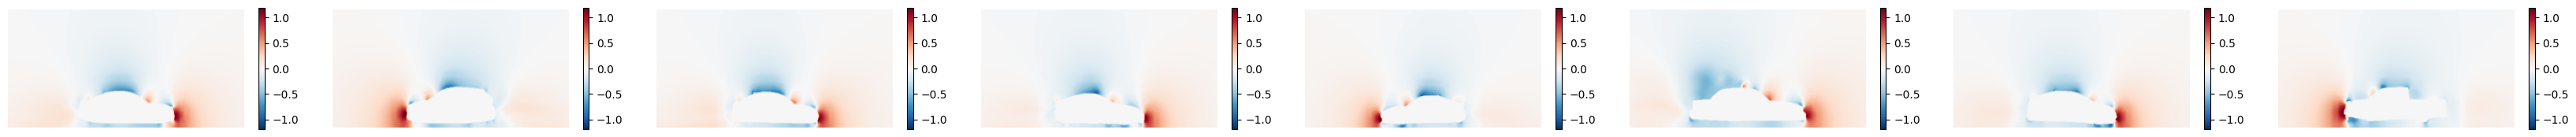

torch.Size([8, 1, 128, 256]) torch.Size([8, 1, 128, 256])


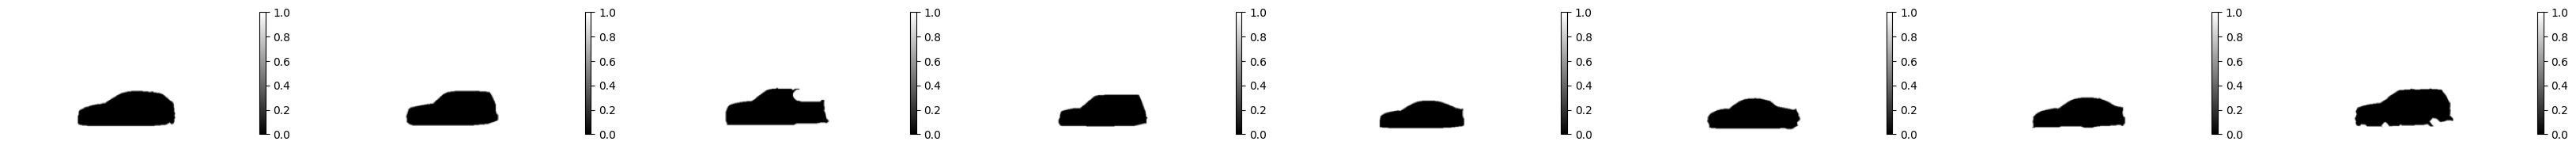

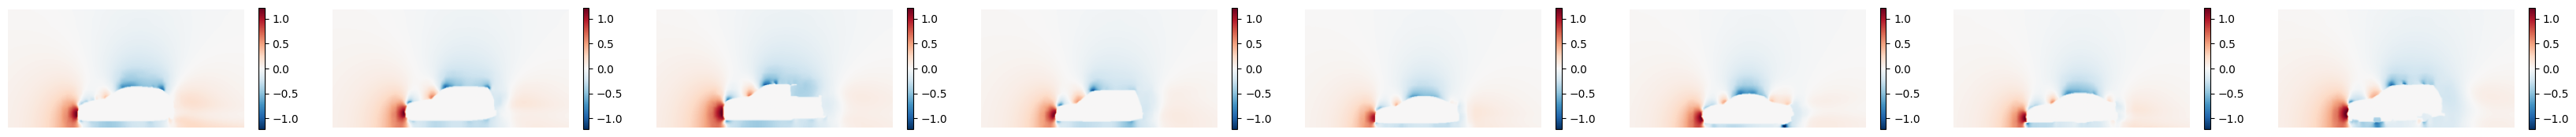

In [ ]:
train_pp = CarFieldPorocess(train_image_paths, train_field_paths, shuffle=True, batch_size=8, aug=True)
test_pp = CarFieldPorocess(test_image_paths, test_field_paths, shuffle=False, batch_size=8, aug=False)

train_xs, train_ys = train_pp.get_batch(0)
print(train_xs.shape, train_ys.shape)
draw(train_xs.numpy()[:,0], mn=0, mx=1, cmap='gray')
draw(train_ys.numpy()[:,0])

test_xs, test_ys = test_pp.get_batch(0)
print(test_xs.shape, test_ys.shape)
draw(test_xs.numpy()[:,0], mn=0, mx=1, cmap='gray')
draw(test_ys.numpy()[:,0])


## **(2) 모델**
---

이번 시간에 사용할 모델은 `UNet`입니다. `UNet`은 주로 이미지 분할 작업에 사용되는 신경망으로, U자형 아키텍처를 통해 다양한 해상도에서 특징을 추출하고 결합하여 높은 성능을 발휘합니다.

`UNet`을 사용하여 이미지 세그멘테이션뿐만 아니라 압력 필드를 예측할 수도 있습니다. 예를 들어, 1채널의 `128x256` 크기 흑백 차량 이미지를 입력으로 받아, 동일한 크기의 1채널 압력 필드를 출력하는 모델을 구축할 수 있습니다. `UNet`의 구조는 이미지의 세부 정보를 잘 유지하면서도 압력 필드 예측과 같은 작업에서 높은 성능을 제공합니다.



### **| Structure 구축**

* 이미지 출처 : (https://arxiv.org/pdf/1505.04597)

<img src="https://github.com/Narnialabs/Narnia-Edu/blob/main/Lecture/imgs/2408_Seoul_02_01.png?raw=true" alt="UNet" width="700"/>



`UNet` 기반 회귀 모델인 `UNetStructure`의 구조를 정의합니다.

```
- __init__ : 사전 학습된 `UNet` 모델을 불러오고 문제에 맞게 적절히 변환합니다.
    - in_channels : 첫번째 컨볼루션 레이어의 입력 channel 개수 입니다.
    - out_channels : 마지막 완전연결 레이어의 출력 feature 개수 입니다.

- forward : 입력 데이터를 모델에 전달하여 예측 값을 반환합니다.
```

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from segmentation_models_pytorch import Unet

# U-Net 모델 정의
class UNetStructure(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNetStructure, self).__init__()
        self.unet = Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=in_channels, classes=out_channels)

    def forward(self, x):
        return self.unet(x)

**UNet 모델 생성**

In [ ]:
unet = UNetStructure(in_channels=1, out_channels=1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 174MB/s]


**모델 입력과 출력 확인**

In [ ]:
x = torch.randn(1, 1, 128, 256)
preds = unet(x)
preds.shape

torch.Size([1, 1, 128, 256])

### **| 모델 구축**

`PyTorch Lightning`을 사용하여 훈련, 검증, 최적화 루틴을 포함하는 `CarhoodPredictor`를 정의합니다.

```
- __init__ : 예측 모델(predictor)을 초기화합니다.
- forward : 입력 데이터를 예측 모델에 전달하여 출력을 반환합니다.
- configure_optimizers : Adam 옵티마이저와 코사인 조정 학습률 스케줄러를 설정합니다.
- training_step : 훈련 배치에서 입력 데이터와 타깃을 받아 모델 출력을 계산하고, MSE 손실을 계산하여 로깅합니다.
- validation_step : 검증 배치에서 입력 데이터와 타깃을 받아 모델 출력을 계산하고, MSE 손실을 계산하여 로깅합니다.
- fit : 훈련 및 검증 데이터를 사용하여 모델을 훈련합니다. 조기 종료와 체크포인트 저장 기능을 포함합니다.
- test_step : 테스트 배치에서 입력 데이터와 타깃을 받아 모델 출력을 계산하고, MSE 성능 지표를 로깅합니다.
- test : 테스트 데이터를 사용하여 모델 성능을 평가합니다.
- infer : 주어진 데이터 로더에서 예측을 수행하고, 필요 시 스케일러를 사용하여 예측값을 역변환합니다.
```

In [ ]:
import torch.nn as nn
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import  CSVLogger

from sklearn.metrics import r2_score, mean_absolute_error


class FieldPredictor(pl.LightningModule):
    def __init__(self, structure, *args, **kwargs):
        super().__init__()
        self.structure = structure

    def forward(self, x):
        x = self.structure(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.init_lr)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.epochs)
        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]

    def training_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss = nn.MSELoss()(output, target)
        lr = self.optimizers().param_groups[0]['lr']

        self.log('train_loss', loss)
        self.log('learning_rate', lr, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss =  nn.MSELoss()(output, target)
        lr = self.optimizers().param_groups[0]['lr']

        self.log('valid_loss', loss)
        return loss


    def fit(self,
            train_loader,
            save_dir,
            valid_loader=None,
            init_lr=1e-3,
            epochs=10,
            patience=5,
            infer_ds = None):

        self.init_lr = init_lr
        self.save_dir = save_dir
        self.epochs = epochs
        self.infer_ds = infer_ds

        # valid loss 기준으로 최적 모델 저장하기
        if valid_loader is not None:
            monitor = 'valid_loss'
        else:
            monitor = 'train_loss'

        checkpoint_callback = ModelCheckpoint(
            dirpath=save_dir,
            filename='ckp_model',
            save_top_k=1,
            verbose=True,
            monitor=monitor,
            mode='min'
        )

        # log
        csv_logger = CSVLogger(save_dir, name="csv_logs")

        # train
        self.trainer = Trainer(
            accelerator='cuda',
            max_epochs=epochs,
            default_root_dir=save_dir,
            callbacks=[checkpoint_callback],
            logger=[csv_logger],
            log_every_n_steps=len(train_loader)
        )

        self.trainer.fit(self, train_dataloaders=train_loader, val_dataloaders=valid_loader)


    def test_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)

        loss = nn.MSELoss()(output, target)
        self.log('test_loss', loss)


    def test(self, data_loader, device='cuda'):
        self.trainer = Trainer(
            accelerator=device,
        )
        results = self.trainer.test(self, dataloaders=data_loader)
        return results


    def on_train_epoch_end(self):
        imgs=[]
        xs, ys = self.infer_ds
        preds = self(xs.cuda())

        xs = xs.numpy()[:,0]
        ys = ys.numpy()[:,0]
        preds = preds.detach().cpu().numpy()[:,0]

        imgs.extend(xs)
        imgs.extend(ys)
        imgs.extend(preds)


        if bool(imgs):
            epoch = self.trainer.current_epoch
            draw(np.array(imgs),
                     save_path=f'./{self.save_dir}/sample_epoch_{epoch:05d}.png',
                     rows=3,
                    )

### | **학습 및 평가**

**모델 인스턴스**

In [ ]:
model = FieldPredictor(structure=unet)

**학습**

In [ ]:
train_loader = train_pp.get_loader()
test_loader = test_pp.get_loader()

model.fit(train_loader, save_dir='unet_field', valid_loader=test_loader, epochs=30, infer_ds = [test_xs, test_ys])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /content/unet_field exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | structure | UNetStructure | 24.4 M | train
----------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.720    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 42: 'valid_loss' reached 0.01680 (best 0.01680), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 84: 'valid_loss' reached 0.00966 (best 0.00966), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 126: 'valid_loss' reached 0.00673 (best 0.00673), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 168: 'valid_loss' reached 0.00414 (best 0.00414), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 210: 'valid_loss' reached 0.00311 (best 0.00311), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 252: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 294: 'valid_loss' reached 0.00300 (best 0.00300), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 336: 'valid_loss' reached 0.00230 (best 0.00230), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 378: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 420: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 462: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 504: 'valid_loss' reached 0.00207 (best 0.00207), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 546: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 588: 'valid_loss' reached 0.00194 (best 0.00194), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 630: 'valid_loss' reached 0.00192 (best 0.00192), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 672: 'valid_loss' reached 0.00187 (best 0.00187), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 714: 'valid_loss' reached 0.00184 (best 0.00184), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 756: 'valid_loss' reached 0.00175 (best 0.00175), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 798: 'valid_loss' reached 0.00169 (best 0.00169), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 840: 'valid_loss' reached 0.00164 (best 0.00164), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 882: 'valid_loss' reached 0.00164 (best 0.00164), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 924: 'valid_loss' reached 0.00163 (best 0.00163), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 966: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 1008: 'valid_loss' reached 0.00154 (best 0.00154), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 1050: 'valid_loss' reached 0.00152 (best 0.00152), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 1092: 'valid_loss' reached 0.00150 (best 0.00150), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 1134: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 1176: 'valid_loss' reached 0.00148 (best 0.00148), saving model to '/content/unet_field/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 1218: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 1260: 'valid_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


**테스트**

In [ ]:
model = FieldPredictor.load_from_checkpoint('./unet_field/ckp_model.ckpt', structure=unet)
model.test(test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0014793946174904704   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0014793946174904704}]

In [ ]:
test_xs, test_ys = test_pp.get_batch(0)
preds = model(test_xs)

test_xs = test_xs.numpy()[:,0]
test_ys = test_ys.numpy()[:,0]
preds = preds.detach().cpu().numpy()[:,0]

# scale 조정
test_ys = (test_ys + 1. ) / 2.
preds = (preds + 1. ) / 2.

diffs = np.abs(test_ys - preds)

print(train_xs.shape, test_ys.shape, preds.shape, diffs.shape)

torch.Size([8, 1, 128, 256]) (8, 128, 256) (8, 128, 256) (8, 128, 256)


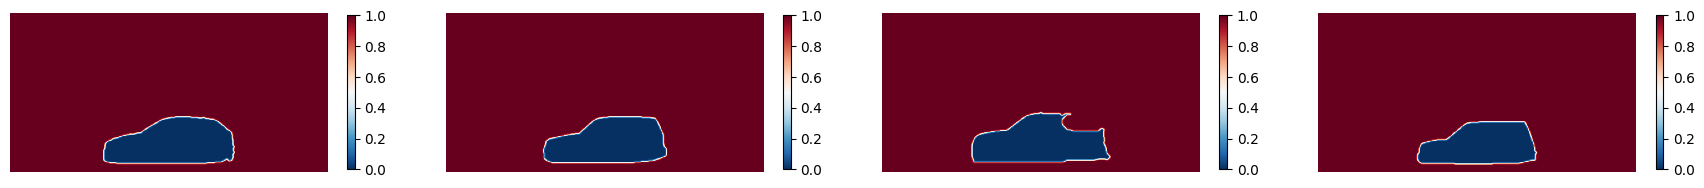

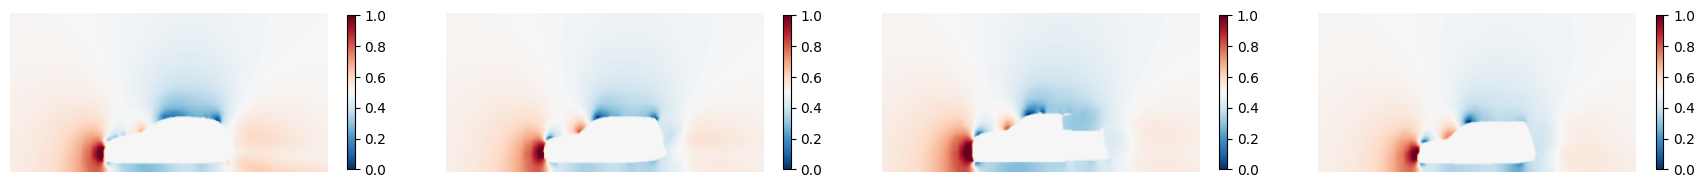

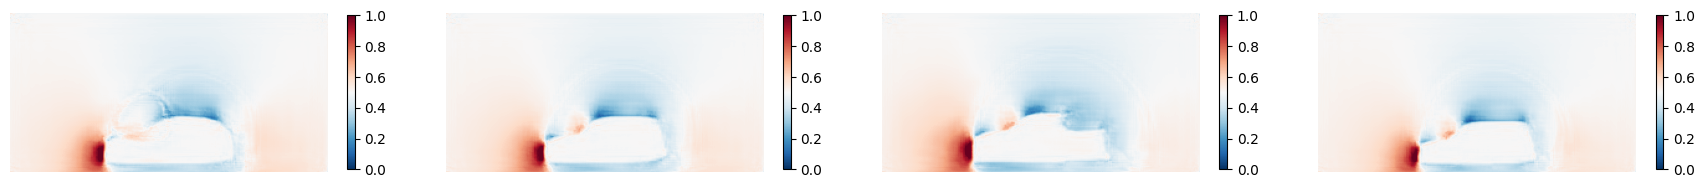

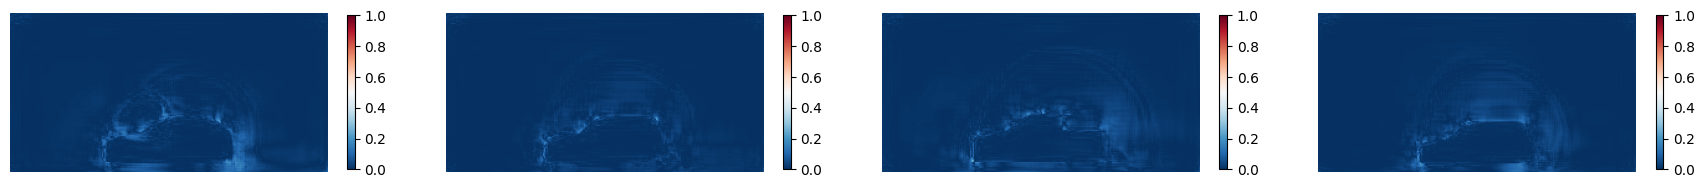

In [ ]:
draw(test_xs[:4], mn=0., mx=1., cmap='gray') # input image
draw(test_ys[:4], mn=0., mx=1. ) # real field map
draw(preds[:4], mn=0., mx=1.) # model field map
draw(diffs[:4], mn=0., mx=1.) # error map